# **Requirements**

Python 3.8.10

pythonnet 2.5.2

`pip install pythonnet==2.5.2`

In [1]:
from classes.base_interactive import PythonZOSConnection
from classes.beam_shaper import BeamShaper
import sys
from importlib import metadata
import numpy as np
import matplotlib.pyplot as plt

print("Python version: ", sys.version)
print('Pythonnet version:', metadata.version('pythonnet'))

Python version:  3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
Pythonnet version: 2.5.2


# **Connect to Zemax and initiate a system**

In [2]:
zos = PythonZOSConnection()
ZOSAPI = zos.ZOSAPI
TheApplication = zos.TheApplication
TheSystem = zos.TheSystem

# TheSystem.Mode = ZOSAPI.ZOSAPI_Mode.Plugin
TheSystem.UpdateMode = ZOSAPI.LensUpdateMode.AllWindows

print('Connected to OpticStudio')
# The connection should now be ready to use.  For example:
print('Serial #: ', TheApplication.SerialCode)

print('ZOSAPI Mode: ', TheSystem.Mode)
print("Lens update mode: ", TheSystem.UpdateMode)

Connected to OpticStudio
Serial #:  20120530
ZOSAPI Mode:  0
Lens update mode:  2


In [21]:
galilean = BeamShaper(omega_0 = 2.366,
                  R_max=4.05,
                  r_max=4.05,
                  d=150,
                  n=1.46071,
                  type='Galilean'
                )

# **Set System Data**

In [22]:
# Define System Explore
SysExplore = TheSystem.SystemData

## **Set Title and Notes**

In [23]:
# Set Title and Notes
SysExplore.TitleNotes.Title = "Galilean Beam Shaper"
SysExplore.TitleNotes.Notes = "Galilean beam shaper design, turning a Gaussian into a flat-top beam."
SysExplore.TitleNotes.Author = "Ziyi Xiong"

## **Set Aperture**

In [24]:
# Set Aperture
SysExplore.Aperture.ApertureType = ZOSAPI.SystemData.ZemaxApertureType.EntrancePupilDiameter
SysExplore.Aperture.ApertureValue = galilean.r_max * 2

SysExplore.Aperture.ApodizationType = 1 # 0: Uniform, 1: Gaussian, 2: Cosine Cubed
SysExplore.Aperture.ApodizationFactor = galilean.apodization_factor # Apodization factor for Gaussian

## **Set Fields**

In [25]:
# Set Fields
SysExplore.Fields.SetFieldType(ZOSAPI.SystemData.FieldType.ParaxialImageHeight)
#SysExplore.Fields.ApplyFieldWizard(ZOSAPI.SystemData.FieldPattern.EqualAreaY, 9, 6.6, 0, 0, 0, True, False)

## **Set Wavelengths**

### **Via Presets**

In [26]:
# SysExplore.Wavelengths.SelectWavelengthPreset(ZOSAPI.SystemData.WavelengthPreset.FdC_Visible)

### **Customize Wavelengths**

In [27]:
SysExplore.Wavelengths.GetWavelength(1).Wavelength = 0.532

### **Remove Wavelengths**

In [28]:
# if num_wavelengths > 1: [SysExplore.Wavelengths.RemoveWavelength(i) for i in range(num_wavelengths, 1, -1)]

# **Set Lens Data**

In [29]:
SysLDE = TheSystem.LDE

## **Add Surfaces**

In [30]:
num_surfaces = SysLDE.NumberOfSurfaces

if num_surfaces == 3:
    for i in range(5): # range(5) = [0, 1, 2, 3, 4]
        SysLDE.AddSurface()

num_surfaces = SysLDE.NumberOfSurfaces
print("Number of surfaces after insertion: ", num_surfaces)

Number of surfaces after insertion:  8


## **Get and Set Surfaces**

In [31]:
# Use a list to store all surfaces objects
Surface=[SysLDE.GetSurfaceAt(i) for i in range(0, num_surfaces)] 

## **Set Surface Data**

### **Set Stop**

In [32]:
Surface[2].IsStop = True 

### **Set Lens Data**

In [33]:
Surface[1].Thickness = 10
Surface[1].Comment = "Dummy"

Surface[2].Thickness = 3
MaterialModel1 = Surface[2].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel1.IndexNd = galilean.n
Surface[2].MaterialCell.SetSolveData(MaterialModel1)
Surface[2].SemiDiameter = galilean.r_max
Surface[2].MechanicalSemiDiameter = galilean.r_max

Surface[3].Thickness = galilean.d
Surface[3].Radius = galilean.r_c1
Surface[3].Conic = galilean.k_1
Surface[3].SemiDiameter = galilean.r_max
Surface[3].MechanicalSemiDiameter = galilean.r_max

Surface[5].Thickness = 3
MaterialModel2 = Surface[5].MaterialCell.CreateSolveType(ZOSAPI.Editors.SolveType.MaterialModel)._S_MaterialModel
MaterialModel2.IndexNd = galilean.n
Surface[5].MaterialCell.SetSolveData(MaterialModel2)
Surface[5].Radius = galilean.r_c2
Surface[5].Conic = galilean.k_2
#Surface[5].SemiDiameter = galilean.R_max
#Surface[5].MechanicalSemiDiameter = galilean.R_max

Surface[6].Thickness = 10
#Surface[6].SemiDiameter = galilean.R_max
#Surface[6].MechanicalSemiDiameter = galilean.R_max

# **Optimization**

## **Set Variables**

In [34]:
Surface[3].RadiusCell.MakeSolveVariable()
Surface[3].ConicCell.MakeSolveVariable()
Surface[5].RadiusCell.MakeSolveVariable()
Surface[5].ConicCell.MakeSolveVariable()

True

## **Set Operands**

In [111]:
TheMFE = TheSystem.MFE

In [36]:
num_operands = TheMFE.NumberOfOperands

num_samples = 81 # best number of sampling points found

if num_operands == 1:
    for i in range(2 * num_samples):
        TheMFE.AddOperand()

num_operands = TheMFE.NumberOfOperands

print(num_operands)

REAY = ZOSAPI.Editors.MFE.MeritOperandType.REAY
REAB = ZOSAPI.Editors.MFE.MeritOperandType.REAB

R_max = Surface[5].SemiDiameter 

162


In [112]:
Operand_REAY = [TheMFE.GetOperandAt(2*i -1) for i in range(1, num_samples + 1)]

In [38]:
for i in range(len(Operand_REAY)):
    Operand_REAY[i].ChangeType(REAY)
    Operand_REAY[i].GetCellAt(2).IntegerValue = 4
    Operand_REAY[i].Weight = 50.0
    py = i / (num_samples - 1) # uniform sampling ensuring sharpe edges
    Operand_REAY[i].GetCellAt(7).DoubleValue = py
    r = galilean.r_max * py
    R = R_max * np.sqrt(1 - np.exp(-2 * (r / galilean.omega_0)**2)) / np.sqrt(1 - np.exp(-2 * (galilean.r_max / galilean.omega_0)**2))
    Operand_REAY[i].Target = R

In [113]:
for i in range(0, 50):
    Operand_REAY[i].Weight = np.abs(Operand_REAY[i].Target - Operand_REAY[i].Value) * 5000.0 # adjust weights based on current error
    
for i in range(51, 81):
    Operand_REAY[i].Weight = np.abs(Operand_REAY[i].Target - Operand_REAY[i].Value) * 1000.0

In [40]:
Operand_REAB = [TheMFE.GetOperandAt(2*i) for i in range(1, num_samples + 1)]
for i in range(len(Operand_REAB)):
    Operand_REAB[i].ChangeType(REAB)
    Operand_REAB[i].GetCellAt(2).IntegerValue = 7 # Nummber of surface
    Operand_REAB[i].Weight = 1.0
    py = i / (num_samples - 1)
    Operand_REAB[i].GetCellAt(7).DoubleValue = py
    Operand_REAB[i].Target = 0.0

In [ ]:
EFFL = ZOSAPI.Editors.MFE.MeritOperandType.EFFL
# TheMFE.AddOperand()
Operand_EFFL = TheMFE.GetOperandAt(num_operands)
Operand_EFFL.ChangeType(EFFL)
Operand_EFFL.Target = 1e+10
Operand_EFFL.Weight = 1

## **Optimize**

In [54]:
LocalOpt = TheSystem.Tools.OpenLocalOptimization()
LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
LocalOpt.NumberOfCores = 16
LocalOpt.RunAndWaitForCompletion()
LocalOpt.Close()

True

# **Analysis**

In [3]:
TheAna = TheSystem.Analyses
num_analyses = TheAna.NumberOfAnalyses
print(num_analyses)
#help(TheAna)

3


In [4]:
for i in range(1, num_analyses+1): 
    ana = TheAna.Get_AnalysisAtIndex(i)
    print(f"Analysis {i}: {ana.GetAnalysisName}")

Analysis 1: Draw2D
Analysis 2: GeometricImageAnalysis
Analysis 3: GeometricImageAnalysis


In [200]:
#TheAna.CloseAnalysis(1)
#TheAna.CloseAnalysis(2)
#TheAna.New_GeometricImageAnalysis()

In [5]:
GeoImgAna1 = TheAna.Get_AnalysisAtIndex(3)
GeoImgAna1.GetAnalysisName
#help(GeoImgAna)

'GeometricImageAnalysis'

In [11]:
GIA_Settings1 = GeoImgAna1.GetSettings()
help(GIA_Settings1)

Help on AS_GeometricImageAnalysis object:

class AS_GeometricImageAnalysis(ZemaxUI.ZOSAPI.Analysis.AS_Base)
 |  Void .ctor(ZemaxUI.ZOSAPI.Analysis.ZemaxAnalyses, ZOSAPI.Analysis.DataID)
 |  
 |  Method resolution order:
 |      AS_GeometricImageAnalysis
 |      ZemaxUI.ZOSAPI.Analysis.AS_Base
 |      ZemaxUI.Common.ViewModels.ZAPI_BaseObject
 |      System.MarshalByRefObject
 |      System.Object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature

In [7]:
GIA_Settings1.Surface.SetSurfaceNumber(-1)
print(GIA_Settings1.Surface.GetSurfaceNumber())
#help(GIA_Settings1.Surface)

-1


In [8]:
print(GIA_Settings1.RaysX1000)
GIA_Settings1.RaysX1000 = 500000
#help(GIA_Settings1.RaysX1000)

500000


In [9]:
print(GIA_Settings1.ImageSize)
GIA_Settings1.ImageSize = 15.0
#help(GIA_Settings1.ImageSize)

15.0


In [10]:
# ShowAsTypes: Surface, Contour, GreyScale, InverseGreyScale, FalseColor, InverseFalseColor, SpotDiagram, CrossX, CrossY
GIA_Settings1.ShowAs = ZOSAPI.Analysis.GiaShowAsTypes.CrossX
GIA_Settings1.get_ShowAs()

7

In [12]:
GIA_Settings1.NumberOfPixels = 200

In [ ]:
# Doesn't work
GIA_Settings1.UpdateUI

<bound method 'UpdateUI'>

In [13]:
GeoImgAna1.ApplyAndWaitForCompletion()

In [ ]:
#GeoImgAna.Terminate()

True

In [14]:
GIA_Results1 = GeoImgAna1.GetResults()
#help(GIA_Results)

In [15]:
print(GIA_Results1.NumberOfDataGrids)
data1 = GIA_Results1.DataGrids[0]
#help(data1)

1


In [21]:
help(data1.Values)

Help on Double[,] object:

class Double[,](Array)
 |  Void .ctor()
 |  
 |  Method resolution order:
 |      Double[,]
 |      Array
 |      Object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __len__(self, /)
 |      Return len(self).
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 | 

In [23]:
print(data1.Values.Length)
print(data1.Values.GetLength(0))

40000
200


Text(0.5, 1.0, 'Geometric Image Analysis')

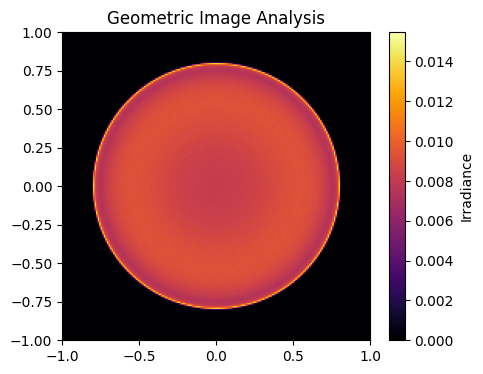

In [25]:
# Convert .NET array to NumPy
vals = zos.reshape(data1.Values, data1.Values.GetLength(0), data1.Values.GetLength(1))
vals = np.asarray(vals, dtype=float)
# Infer square grid (GIA defaults to 100×100)
side = int(np.sqrt(vals.size))
img = vals.reshape(side, side)

# Show the 2D image
plt.figure(figsize=(5, 4))
plt.imshow(img, extent=[-1 , 1, -1, 1], origin="lower", cmap="inferno")
plt.colorbar(label="Irradiance")
plt.title("Geometric Image Analysis")


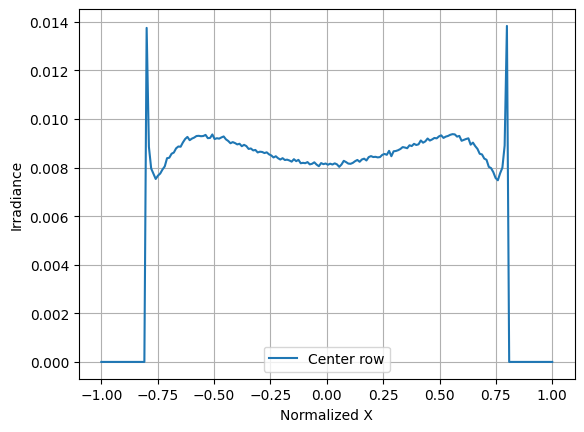

In [26]:
# Cross section through the center
mid = side // 2
x = np.linspace(-1, 1, side)
plt.figure()
plt.plot(x, img[mid, :], label="Center row")
plt.xlabel("Normalized X")
plt.ylabel("Irradiance")
plt.grid()
plt.legend()
plt.show()